In [142]:
#all imports, library setups here
import pandas as pd
import numpy as np
import matplotlib

from scipy import stats, integrate

import matplotlib.pyplot as plt
%matplotlib inline
import cufflinks as cf

import plotly
plotly.offline.init_notebook_mode()
import plotly.offline as py
import plotly.graph_objs as go
from plotly.graph_objs import *
print(pd.__version__)

import seaborn as sns
sns.set(color_codes=True)
#sns.set_context('poster')
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}

import sklearn as sk
import sklearn.cluster as cluster
from sklearn import linear_model
regr = linear_model.LinearRegression()
import re

import statsmodels.formula.api as sm
import time

0.18.1


In [198]:
evolutionDF = pd.read_csv('EvolutionPopUSA_MainData.csv',sep=",",header='infer')
evolutionDF.track_name = [re.sub(r"\(.*\)","", track) for track in evolutionDF.track_name]
evolutionDF.track_name = [track.strip() for track in evolutionDF.track_name]

In [197]:
dtypespec = {"weeks": object, "peak": object, "var9": object, "var10": object, "var11": object, "var12": object, "var13": object}
billboardDF = pd.read_csv('us_billboard.csv', sep=",", header='infer', dtype=dtypespec)
# remove the garbage characters from the title field
billboardDF['track_name'] = billboardDF['track_name'].map(lambda x: str(x)[3:])
billboardDF.track_name = [re.sub(r"\(.*\)","", track) for track in billboardDF.track_name]
billboardDF.track_name = [track.strip() for track in billboardDF.track_name]

In [11]:
evolutionDF.dtypes

recording_id           int64
artist_name           object
artist_name_clean     object
track_name            object
first_entry           object
quarter               object
year                   int64
fiveyear               int64
decade                 int64
era                    int64
cluster                int64
hTopic_01            float64
hTopic_02            float64
hTopic_03            float64
hTopic_04            float64
hTopic_05            float64
hTopic_06            float64
hTopic_07            float64
hTopic_08            float64
tTopic_01            float64
tTopic_02            float64
tTopic_03            float64
tTopic_04            float64
tTopic_05            float64
tTopic_06            float64
tTopic_07            float64
tTopic_08            float64
PC1                  float64
PC2                  float64
PC3                  float64
                      ...   
timb_06                int64
timb_07                int64
timb_08                int64
timb_09       

In [34]:
billboardDF.dtypes

this_week_position      int64
last_week_position     object
peak                   object
weeks                  object
track_name             object
artist                 object
entry_date             object
entry_position         object
var9                   object
var10                  object
var11                  object
var12                  object
var13                  object
Unnamed: 13           float64
Unnamed: 14           float64
Unnamed: 15           float64
Unnamed: 16           float64
dtype: object

In [203]:
billboardDF.head()

this_week_position last_week_position peak weeks  \
0                   1                  1    1     5   
1                   2                  2    1    13   
2                   3                  3    3     9   
3                   4                NEW    4     1   
4                   5                  4    4    14   

                   track_name                                   artist  \
0                Shape Of You                            'b'ED SHEERAN   
1              Bad And Boujee          'b'MIGOS featuring LIL UZI VERT   
2  I Don't Wanna Live Forever                   "b'ZAYN / TAYLOR SWIFT   
3             Million Reasons                             'b'LADY GAGA   
4                  Bad Things   'b'MACHINE GUN KELLY x CAMILLA CABELLO   

     entry_date entry_position var9 var10     var11 var12 var13  Unnamed: 13  \
0   '2017-01-28              1    1     5  20170225   NaN   NaN          NaN   
1   '2016-12-03             76    1    13  20170225   NaN   NaN          NaN   
2   '2016-12-31              6    3     9  20170225   NaN   NaN          NaN   
3   '2017-02-25              4    4     1  20170225   NaN   NaN          NaN   
4   '2016-11-26             73    4    14  20170225   NaN   NaN          NaN   

   Unnamed: 14  Unnamed: 15  Unnamed: 16  
0          NaN          NaN          NaN  
1          NaN          NaN          NaN  
2          NaN          NaN          NaN  
3          NaN          NaN          NaN  
4          NaN          NaN          NaN

In [230]:
# I only care about the tracks in the evolution dataset, but songs are 
# repeated in the billboard dataset as many times as weeks they were on 
# the list
# For each unique track name, I want the max weeks and peak, lowest 
# position, and average position
# lol how?
count=0;
uniqueTracks = evolutionDF.track_name.unique()
#temporarily take top 50 for testing
#uniqueTracks = uniqueTracks[0:50]
columns = ['track_name', 'weeks', 'max_rank', 'min_rank', 'avg_rank']
uniqueTracksDF = pd.DataFrame(index=uniqueTracks, columns = columns)


In [231]:
for trackName in uniqueTracks:
    #df = billboardDF[billboardDF.track_name.isin([trackName])]
    #df = billboardDF[billboardDF.track_name.equals(trackName)]
    df = billboardDF[billboardDF['track_name'] == trackName]
    maxWeeks = df['weeks'].max(axis=0)
    maxRank = df['this_week_position'].max(axis=0)
    minRank = df['this_week_position'].min(axis=0)
    avgRank = df['this_week_position'].mean(axis=0)
    uniqueTracksDF.set_value(trackName, 'track_name', trackName)
    uniqueTracksDF.set_value(trackName, 'weeks', maxWeeks)
    uniqueTracksDF.set_value(trackName, 'max_rank', maxRank)
    uniqueTracksDF.set_value(trackName, 'min_rank', minRank)
    uniqueTracksDF.set_value(trackName, 'avg_rank', avgRank)

In [232]:
len(uniqueTracksDF)

14601

In [233]:
uniqueTracksDF.head(5)

track_name weeks max_rank min_rank avg_rank
Solitude Standing    Solitude Standing     3       97       94  95.3333
Son Of A Gun              Son Of A Gun     9       88       28  48.3333
Heart                            Heart     9      135       15  69.7179
Kisses On The Wind  Kisses On The Wind     9       79        8  36.1429
Get Money                    Get Money     9       55       17     40.6

In [234]:
uniqueTracksDF.isnull().sum()
uniqueTracksDF.dtypes

track_name    object
weeks         object
max_rank      object
min_rank      object
avg_rank      object
dtype: object

In [237]:
musicDF = pd.merge(evolutionDF, uniqueTracksDF, how='left', on=['track_name'])

In [238]:
musicDF.dtypes

recording_id           int64
artist_name           object
artist_name_clean     object
track_name            object
first_entry           object
quarter               object
year                   int64
fiveyear               int64
decade                 int64
era                    int64
cluster                int64
hTopic_01            float64
hTopic_02            float64
hTopic_03            float64
hTopic_04            float64
hTopic_05            float64
hTopic_06            float64
hTopic_07            float64
hTopic_08            float64
tTopic_01            float64
tTopic_02            float64
tTopic_03            float64
tTopic_04            float64
tTopic_05            float64
tTopic_06            float64
tTopic_07            float64
tTopic_08            float64
PC1                  float64
PC2                  float64
PC3                  float64
                      ...   
timb_10                int64
timb_11                int64
timb_12                int64
timb_13       

In [241]:
#musicSubset = musicDF.ix[0,0:27].copy()
musicSubset = pd.concat([musicDF.ix[:,0:27],musicDF.ix[:,269:273]], axis=1)

In [242]:
musicSubset.dtypes

recording_id           int64
artist_name           object
artist_name_clean     object
track_name            object
first_entry           object
quarter               object
year                   int64
fiveyear               int64
decade                 int64
era                    int64
cluster                int64
hTopic_01            float64
hTopic_02            float64
hTopic_03            float64
hTopic_04            float64
hTopic_05            float64
hTopic_06            float64
hTopic_07            float64
hTopic_08            float64
tTopic_01            float64
tTopic_02            float64
tTopic_03            float64
tTopic_04            float64
tTopic_05            float64
tTopic_06            float64
tTopic_07            float64
tTopic_08            float64
weeks                 object
max_rank              object
min_rank              object
avg_rank              object
dtype: object

In [243]:
musicSubset.isnull().sum()

recording_id            0
artist_name             0
artist_name_clean       0
track_name              0
first_entry             0
quarter                 0
year                    0
fiveyear                0
decade                  0
era                     0
cluster                 0
hTopic_01               0
hTopic_02               0
hTopic_03               0
hTopic_04               0
hTopic_05               0
hTopic_06               0
hTopic_07               0
hTopic_08               0
tTopic_01               0
tTopic_02               0
tTopic_03               0
tTopic_04               0
tTopic_05               0
tTopic_06               0
tTopic_07               0
tTopic_08               0
weeks                1690
max_rank             1690
min_rank             1690
avg_rank             1690
dtype: int64

In [244]:
musicSubset['weeks'] = musicSubset['weeks'].convert_objects(convert_numeric=True)
musicSubset['max_rank'] = musicSubset['max_rank'].convert_objects(convert_numeric=True)
musicSubset['min_rank'] = musicSubset['min_rank'].convert_objects(convert_numeric=True)
musicSubset['avg_rank'] = musicSubset['avg_rank'].convert_objects(convert_numeric=True)

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: FutureWarning:

convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: FutureWarning:

convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: FutureWarning:

convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: FutureWarning:

convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.



In [245]:
musicSubset.dtypes

recording_id           int64
artist_name           object
artist_name_clean     object
track_name            object
first_entry           object
quarter               object
year                   int64
fiveyear               int64
decade                 int64
era                    int64
cluster                int64
hTopic_01            float64
hTopic_02            float64
hTopic_03            float64
hTopic_04            float64
hTopic_05            float64
hTopic_06            float64
hTopic_07            float64
hTopic_08            float64
tTopic_01            float64
tTopic_02            float64
tTopic_03            float64
tTopic_04            float64
tTopic_05            float64
tTopic_06            float64
tTopic_07            float64
tTopic_08            float64
weeks                float64
max_rank             float64
min_rank             float64
avg_rank             float64
dtype: object

In [246]:
#write cluster plot function to help us
def plot_clusters(data, algorithm, args, kwds):
    start_time = time.time()
    labels = algorithm(*args, **kwds).fit_predict(data)
    end_time = time.time()
    palette = sns.color_palette('deep', np.unique(labels).max() + 1)
    colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in labels]
    plt.scatter(data.T[0], data.T[1], c=colors, **plot_kwds)
    frame = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)
    plt.title('Clusters found by {}'.format(str(algorithm.__name__)), fontsize=24)
    plt.text(-0.5, 0.7, 'Clustering took {:.2f} s'.format(end_time - start_time), fontsize=14)

In [265]:
clusterDF = musicSubset.ix[:,11:27].copy()

In [266]:
clusterDF.dtypes

hTopic_01    float64
hTopic_02    float64
hTopic_03    float64
hTopic_04    float64
hTopic_05    float64
hTopic_06    float64
hTopic_07    float64
hTopic_08    float64
tTopic_01    float64
tTopic_02    float64
tTopic_03    float64
tTopic_04    float64
tTopic_05    float64
tTopic_06    float64
tTopic_07    float64
tTopic_08    float64
dtype: object

In [ ]:
clusterDF = clusterDF.as_matrix()

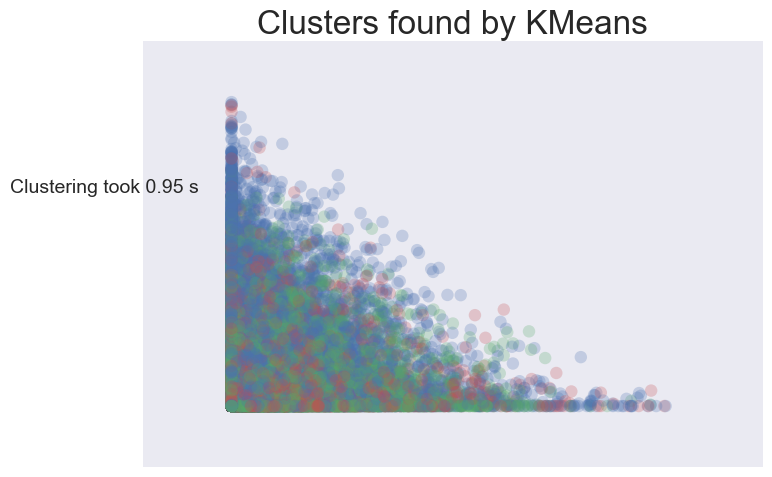

In [269]:
#centroid based clustering
#k-means (loyds algorithm)
# assign data points to nearest cluster based on a distance metric
# calculate new centroids of clusters; repeat first step
# algorithm has converged when data points don't change cluster affiliations
plot_clusters(clusterDF,cluster.KMeans,(),{'n_clusters':3})
# so this doesn't seem very useful

In [251]:
# partition into testing and training
np.random.seed(0)
indices = np.random.permutation(len(clusterDF))
trainingX = clusterDF[:-20]
trainingYear = musicSubset['year'][:-20]
trainingDecade = musicSubset['decade'][:-20]
trainingPeak = musicSubset['max_rank'][:-20]
trainingWeeks = musicSubset['weeks'][:-20]

testingX = clusterDF[-20:]
testingYear = musicSubset['year'][-20:]
testingDecade = musicSubset['decade'][-20:]
testingPeak = musicSubset['max_rank'][-20:]
testingWeeks = musicSubset['weeks'][-20:]

In [252]:
regr.fit(trainingX, trainingYear)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [253]:
print(regr.coef_)

[ -1.29498914e+14  -1.29498914e+14  -1.29498914e+14  -1.29498914e+14
  -1.29498914e+14  -1.29498914e+14  -1.29498914e+14  -1.29498914e+14
   5.18113009e+12   5.18113009e+12   5.18113009e+12   5.18113009e+12
   5.18113009e+12   5.18113009e+12   5.18113009e+12   5.18113009e+12]


In [254]:
np.mean((regr.predict(testingX)-testingYear)**2)

316.255859375

In [255]:
regr.score(trainingX, trainingYear)

0.22467462911040503

In [256]:
regr.score(testingX, testingYear)

0.077507319643260852

In [257]:
# hmm so 0 means no linear relationship for year
res = regr.fit(trainingX, trainingDecade)
regr.score(trainingX, trainingDecade)
regr.score(testingX, testingDecade)

0.1021654006402498

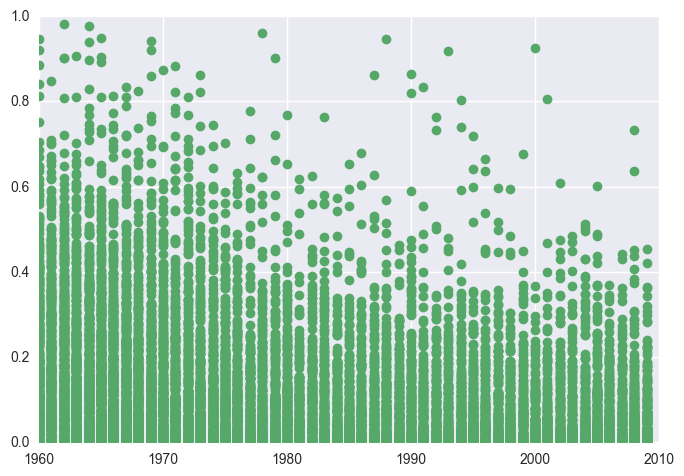

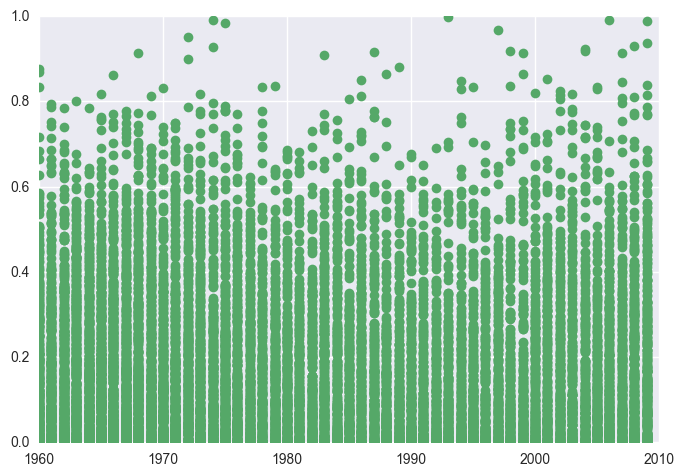

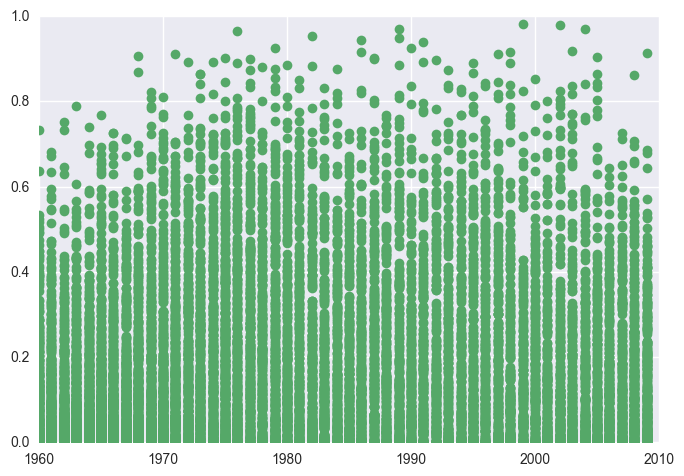

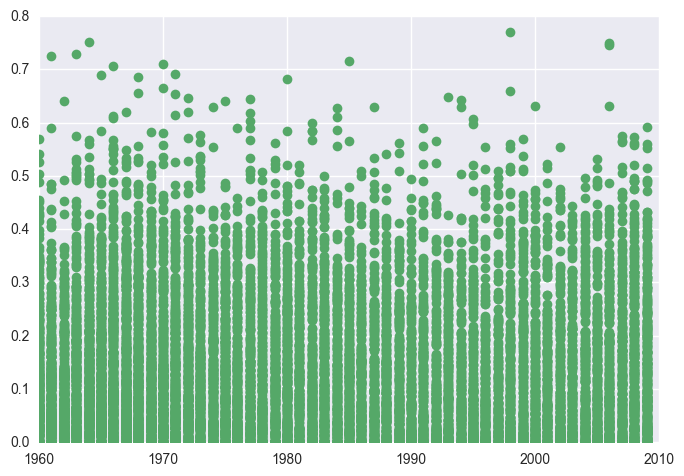

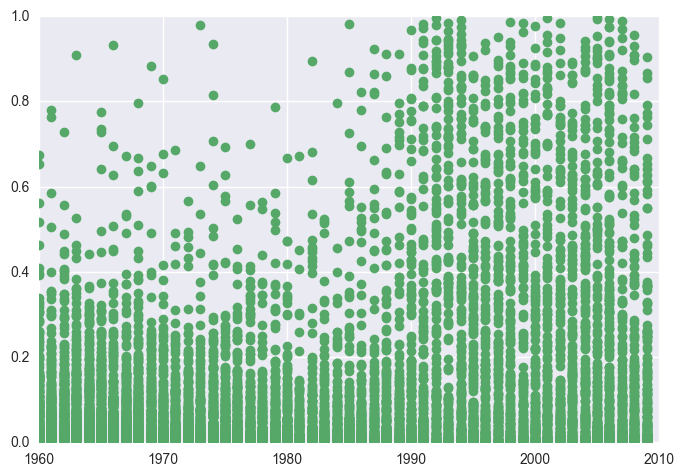

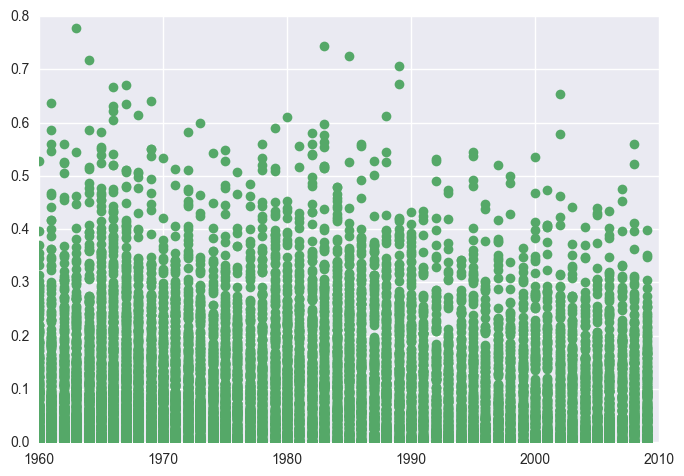

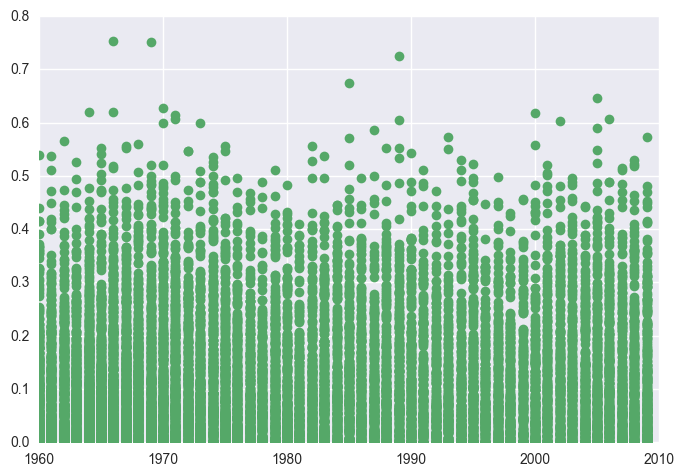

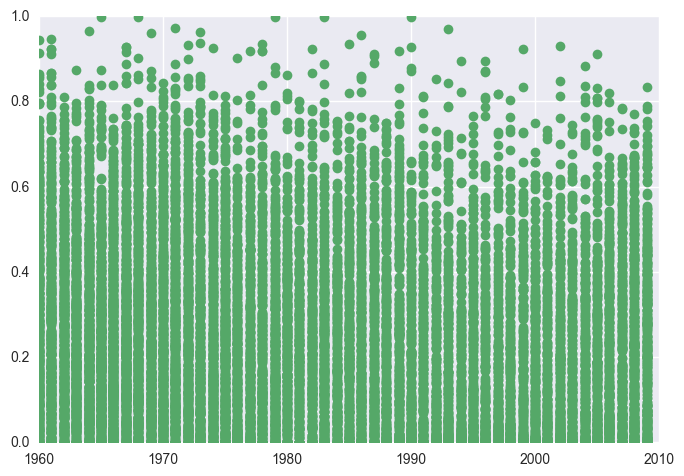

In [258]:
plt.plot(musicSubset.year.values, musicSubset.hTopic_01.values, 'go')
plt.show()
plt.plot(musicSubset.year.values, musicSubset.hTopic_02.values, 'go')
plt.show()
plt.plot(musicSubset.year.values, musicSubset.hTopic_03.values, 'go')
plt.show()
plt.plot(musicSubset.year.values, musicSubset.hTopic_04.values, 'go')
plt.show()
plt.plot(musicSubset.year.values, musicSubset.hTopic_05.values, 'go')
plt.show()
plt.plot(musicSubset.year.values, musicSubset.hTopic_06.values, 'go')
plt.show()
plt.plot(musicSubset.year.values, musicSubset.hTopic_07.values, 'go')
plt.show()
plt.plot(musicSubset.year.values, musicSubset.hTopic_08.values, 'go')
plt.show()

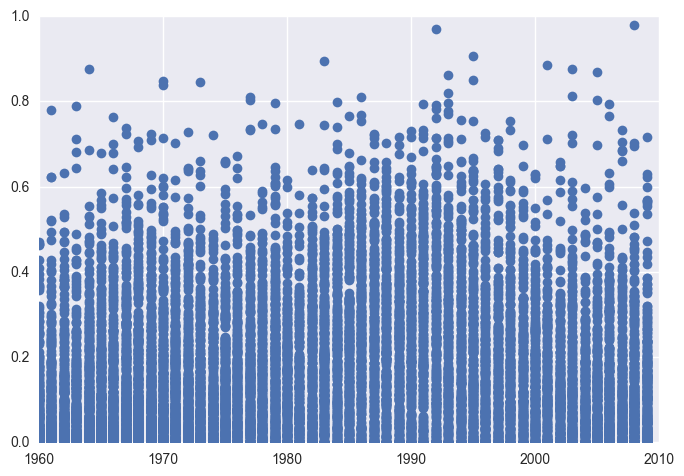

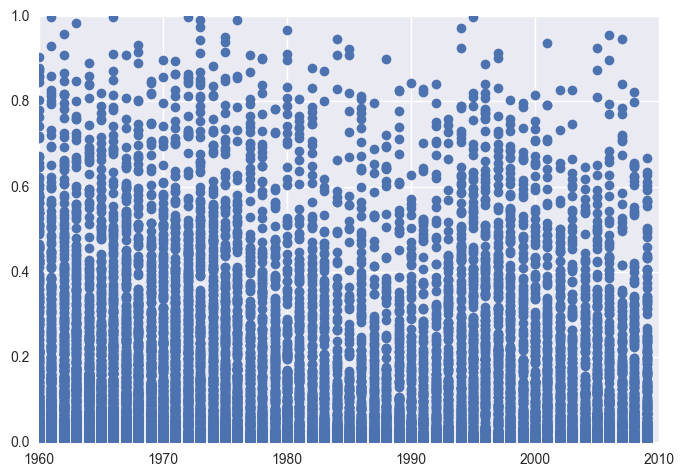

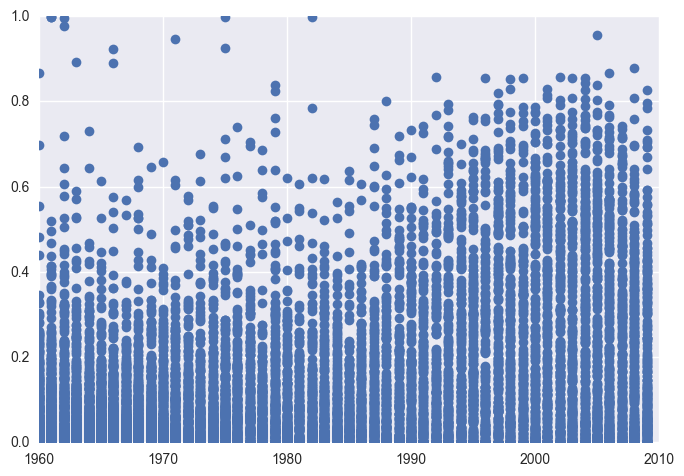

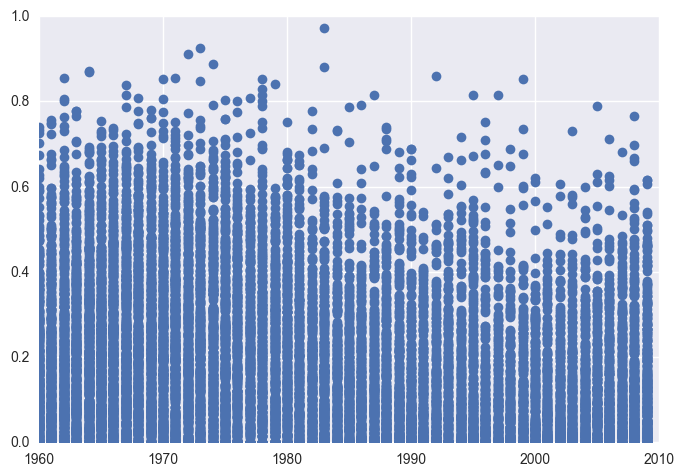

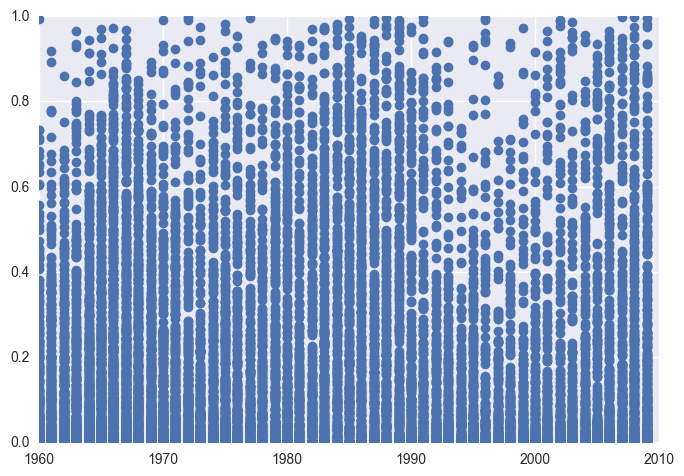

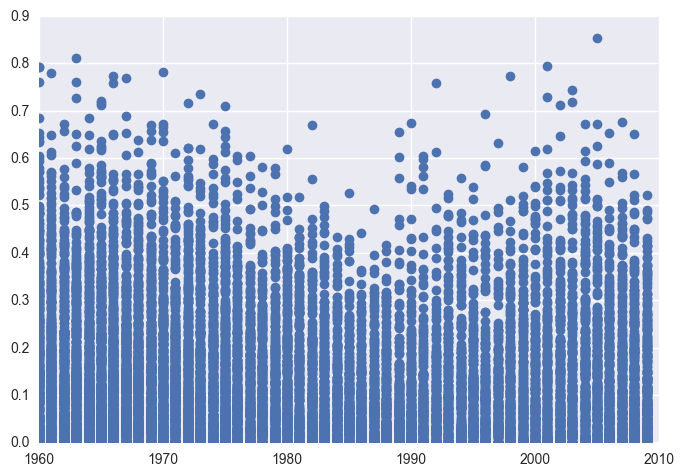

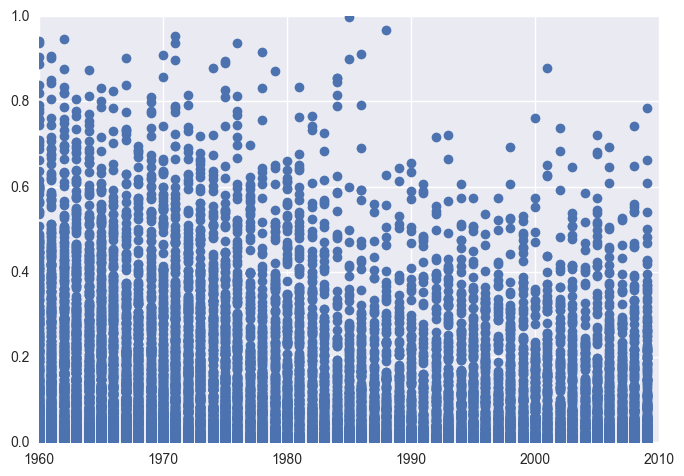

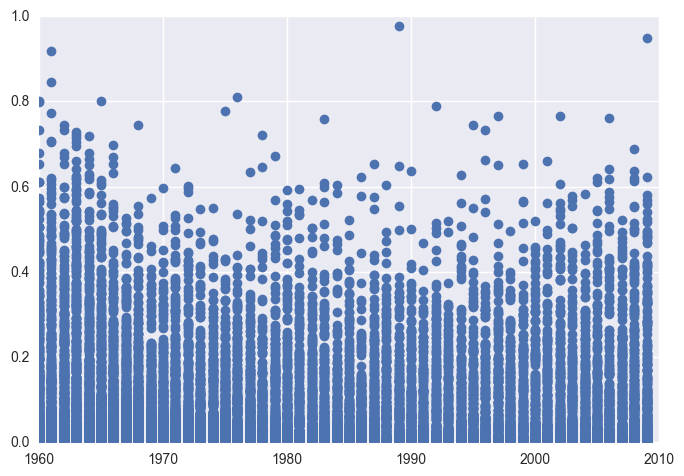

In [259]:
plt.plot(musicSubset.year.values, musicSubset.tTopic_01.values, 'bo')
plt.show()
plt.plot(musicSubset.year.values, musicSubset.tTopic_02.values, 'bo')
plt.show()
plt.plot(musicSubset.year.values, musicSubset.tTopic_03.values, 'bo')
plt.show()
plt.plot(musicSubset.year.values, musicSubset.tTopic_04.values, 'bo')
plt.show()
plt.plot(musicSubset.year.values, musicSubset.tTopic_05.values, 'bo')
plt.show()
plt.plot(musicSubset.year.values, musicSubset.tTopic_06.values, 'bo')
plt.show()
plt.plot(musicSubset.year.values, musicSubset.tTopic_07.values, 'bo')
plt.show()
plt.plot(musicSubset.year.values, musicSubset.tTopic_08.values, 'bo')
plt.show()

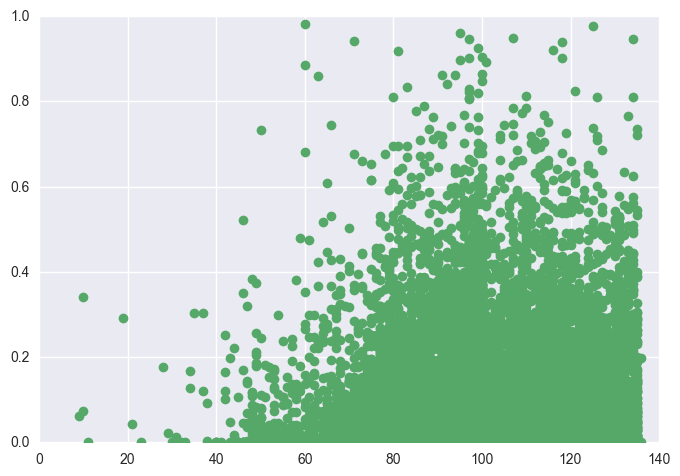

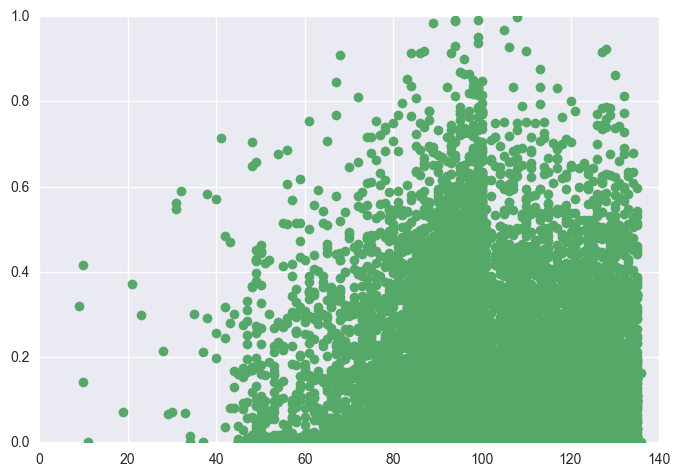

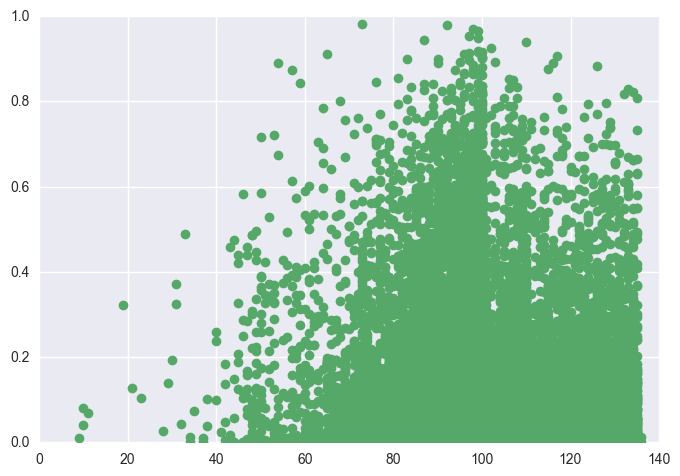

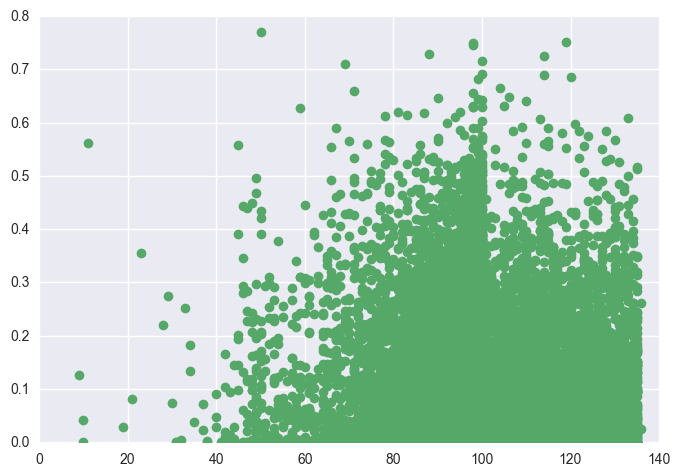

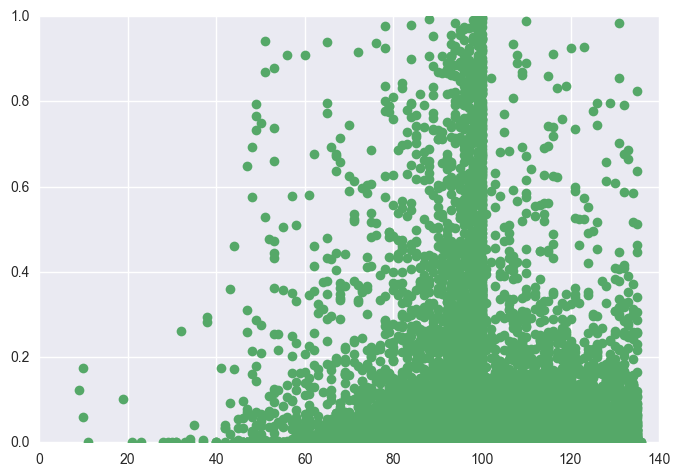

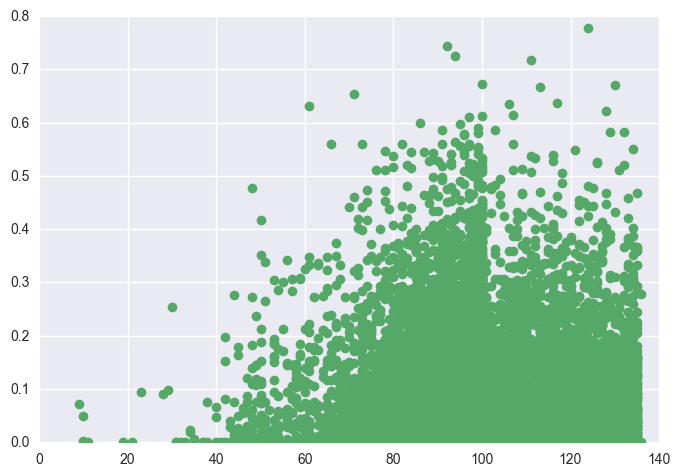

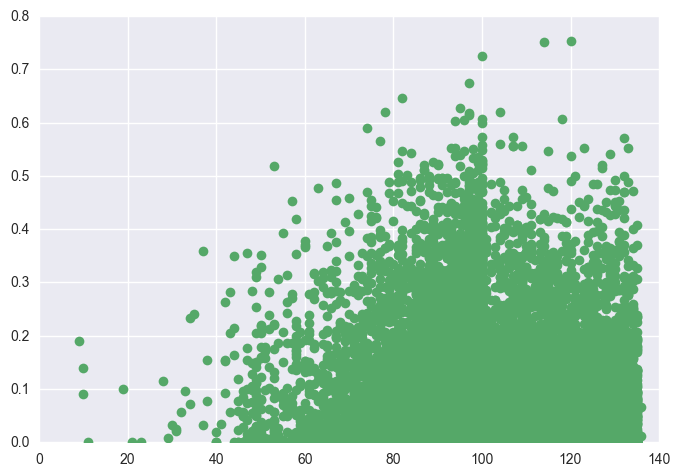

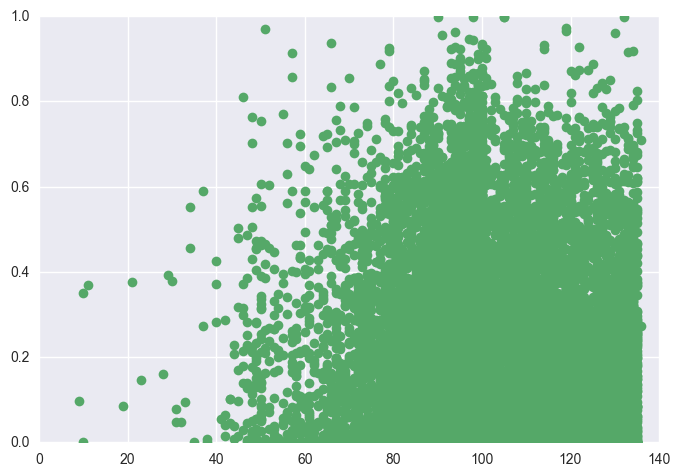

In [261]:
plt.plot(musicSubset.max_rank.values, musicSubset.hTopic_01.values, 'go')
plt.show()
plt.plot(musicSubset.max_rank.values, musicSubset.hTopic_02.values, 'go')
plt.show()
plt.plot(musicSubset.max_rank.values, musicSubset.hTopic_03.values, 'go')
plt.show()
plt.plot(musicSubset.max_rank.values, musicSubset.hTopic_04.values, 'go')
plt.show()
plt.plot(musicSubset.max_rank.values, musicSubset.hTopic_05.values, 'go')
plt.show()
plt.plot(musicSubset.max_rank.values, musicSubset.hTopic_06.values, 'go')
plt.show()
plt.plot(musicSubset.max_rank.values, musicSubset.hTopic_07.values, 'go')
plt.show()
plt.plot(musicSubset.max_rank.values, musicSubset.hTopic_08.values, 'go')
plt.show()

In [ ]:
# I'm not sure if this is relevant, but there seems to something special 
# about peaking at 100. 

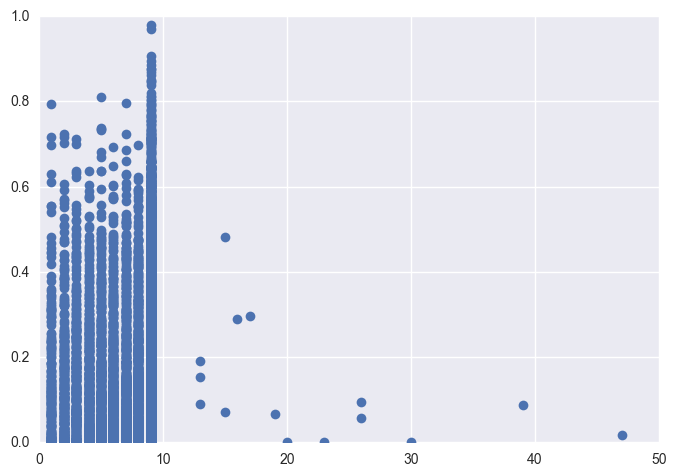

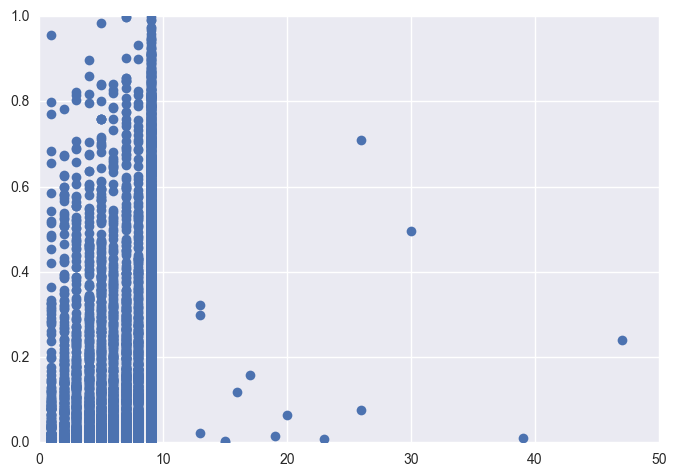

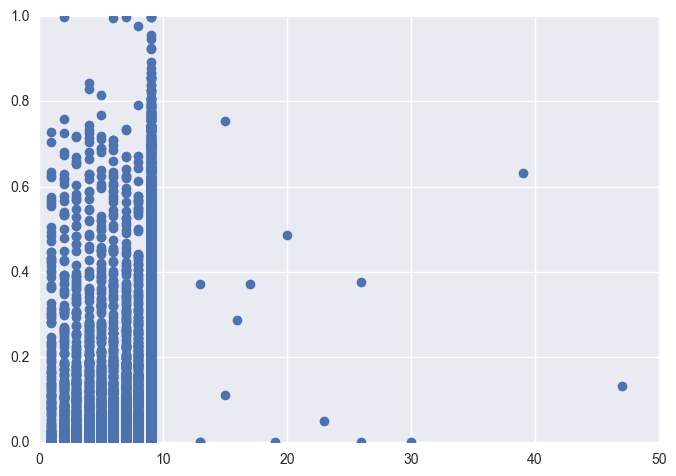

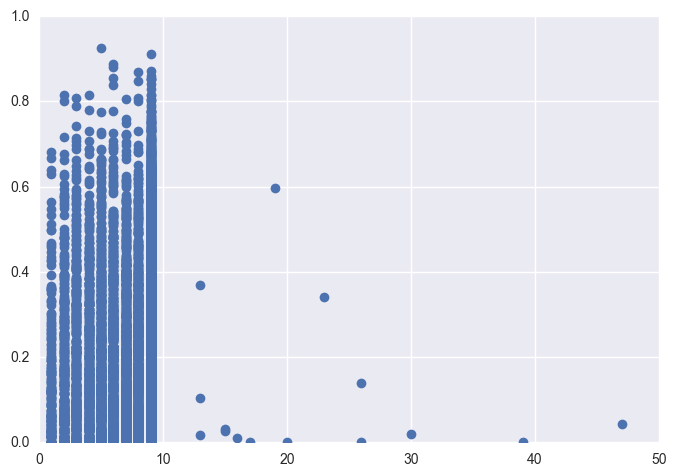

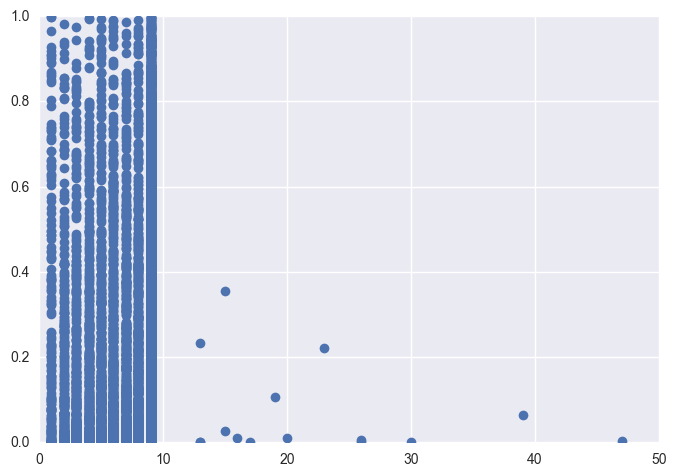

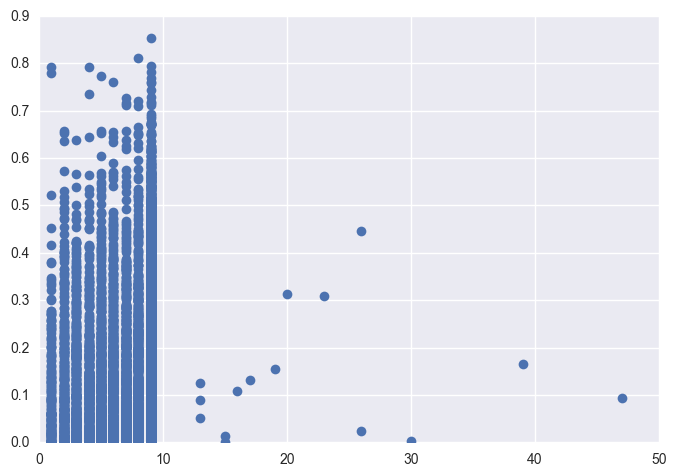

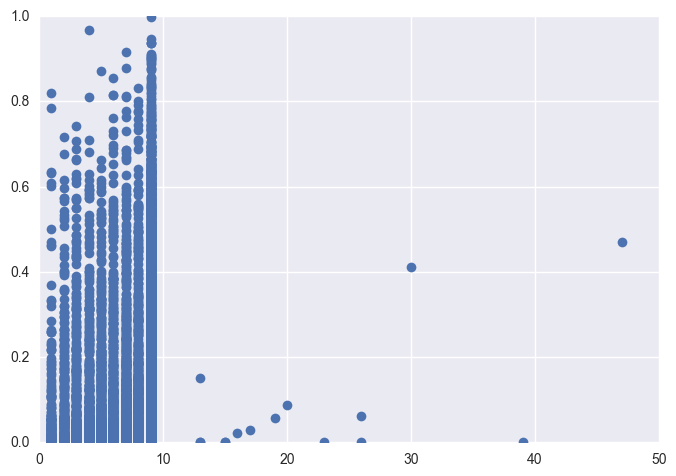

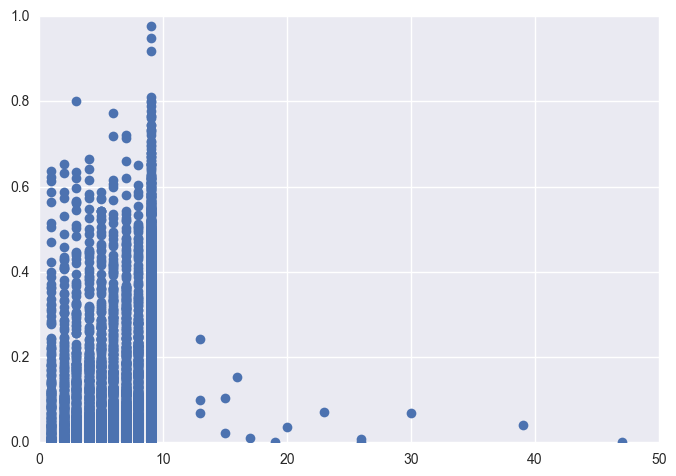

In [262]:
plt.plot(musicSubset.weeks.values, musicSubset.tTopic_01.values, 'bo')
plt.show()
plt.plot(musicSubset.weeks.values, musicSubset.tTopic_02.values, 'bo')
plt.show()
plt.plot(musicSubset.weeks.values, musicSubset.tTopic_03.values, 'bo')
plt.show()
plt.plot(musicSubset.weeks.values, musicSubset.tTopic_04.values, 'bo')
plt.show()
plt.plot(musicSubset.weeks.values, musicSubset.tTopic_05.values, 'bo')
plt.show()
plt.plot(musicSubset.weeks.values, musicSubset.tTopic_06.values, 'bo')
plt.show()
plt.plot(musicSubset.weeks.values, musicSubset.tTopic_07.values, 'bo')
plt.show()
plt.plot(musicSubset.weeks.values, musicSubset.tTopic_08.values, 'bo')
plt.show()

In [263]:
musicSubset.to_csv('musicSubset.csv')